# Order Volume Prediction with Cross-Validation

This notebook implements a neural network model for predicting order volumes, with a focus on robust validation through k-fold cross-validation. The implementation includes:

- A deep neural network with batch normalization and dropout for regularization
- Cyclical encoding of temporal features to capture weekly patterns
- K-fold cross-validation to ensure model stability
- Advanced training techniques including learning rate scheduling and early stopping
- Comprehensive model evaluation across multiple metrics

The goal is to create a reliable and robust model that can accurately predict order volumes while avoiding overfitting through careful validation procedures.

## Setup

Let's start by importing the necessary libraries. Each library serves a specific purpose in our implementation:

- PyTorch (`torch`): The main deep learning framework
- NumPy and Pandas: For data manipulation and numerical operations
- Scikit-learn: For data preprocessing and model validation tools

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Custom Dataset Implementation

A crucial component of any PyTorch-based machine learning pipeline is the Dataset class. This custom implementation:

1. Inherits from PyTorch's Dataset class
2. Handles conversion of features and targets to PyTorch tensors
3. Provides required methods for data loading

In [43]:
class OrderVolumeDataset(Dataset):
    """
    Custom dataset class for handling order volume data.
    Converts features and targets into PyTorch tensors and provides
    necessary methods for DataLoader compatibility.
    """
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

## Neural Network Architecture

Our `OrderVolumePredictor` implements a deep neural network with several key features:

1. Multiple hidden layers with increasing then decreasing dimensionality
2. Batch normalization after each linear layer to stabilize training
3. ReLU activation functions for non-linearity
4. Dropout layers for regularization
5. A final output layer for prediction

This architecture is designed to capture complex patterns while preventing overfitting.

In [60]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.BatchNorm1d(input_dim)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = x
        out = self.block(x)
        out += identity  # Residual connection
        return self.relu(out)

class OrderVolumePredictor(nn.Module):
    def __init__(self, input_dim):
        super(OrderVolumePredictor, self).__init__()
        
        # Initial feature processing
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Residual blocks for deeper feature extraction
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(128, 256),
            ResidualBlock(128, 256),
            ResidualBlock(128, 256)
        ])
        
        # Feature aggregation
        self.aggregation = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Final prediction layer
        self.output_layer = nn.Linear(32, 1)
    
    def forward(self, x):
        # Initial processing
        x = self.input_layer(x)
        
        # Process through residual blocks
        for block in self.residual_blocks:
            x = block(x)
        
        # Final processing
        x = self.aggregation(x)
        x = self.output_layer(x)
        
        return x

## Data Preprocessing

The data preparation pipeline includes several sophisticated steps:

1. Loading and cleaning the raw data
2. Converting temporal features (ORDERWEEK) into cyclical representations
3. Encoding categorical variables using one-hot encoding
4. Scaling numerical features and target variables
5. Splitting data into training and test sets

The cyclical encoding of week numbers is particularly important as it helps the model understand the periodic nature of order patterns throughout the year.

In [75]:
def prepare_data(csv_path, test_size=0.2, random_state=42, n_lags=4):
    """
    Prepare the data for training by reading CSV and preprocessing features.
    Includes enhanced feature engineering with lag features and rolling statistics.
    
    Args:
        csv_path: Path to the CSV file
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
        n_lags: Number of previous weeks to use as lag features
    """
    # Read the CSV file
    df = pd.read_csv(csv_path, encoding='utf-8', quotechar='"', encoding_errors='ignore')
    
    # Convert ORDERWEEK to a proper date format and extract week number
    df['ORDERWEEK'] = df['ORDERWEEK'].apply(lambda x: int(x.split()[1]))
    
    # Sort data by customer and week to ensure proper lag feature creation
    df = df.sort_values(['CUSTOMER_NAME', 'ORDERWEEK'])
    
    # Create cyclical features for the week number (captures yearly patterns)
    df['WEEK_SIN'] = np.sin(2 * np.pi * df['ORDERWEEK']/53)
    df['WEEK_COS'] = np.cos(2 * np.pi * df['ORDERWEEK']/53)
    
    # === New Feature Engineering ===
    
    # Create lag features - previous weeks' order volumes
    for lag in range(1, n_lags + 1):
        df[f'ORDER_LAG_{lag}'] = df.groupby('CUSTOMER_NAME')['ORDERVOLUME'].shift(lag)
    
    # Add rolling statistics for each customer
    # Rolling mean captures the trend
    df['ORDER_ROLLING_MEAN'] = df.groupby('CUSTOMER_NAME')['ORDERVOLUME'].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean())
    
    # Rolling standard deviation captures volatility
    df['ORDER_ROLLING_STD'] = df.groupby('CUSTOMER_NAME')['ORDERVOLUME'].transform(
        lambda x: x.rolling(window=4, min_periods=1).std().fillna(0))
    
    # Remove rows where we don't have complete lag information
    df = df.dropna()
    
    # Separate target variable
    target = df['ORDERVOLUME'].values
    
    # Define features to use
    categorical_columns = ['CUSTOMER_NAME', 'ORDERTYPE', 'WAREHOUSE', 'CITY']
    numerical_columns = [
        'WEEK_SIN', 'WEEK_COS',                          # Cyclical time features
        *[f'ORDER_LAG_{i}' for i in range(1, n_lags + 1)],  # Lag features
        'ORDER_ROLLING_MEAN', 'ORDER_ROLLING_STD'        # Rolling statistics
    ]
    
    # Process categorical features
    categorical_data = df[categorical_columns]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_features = encoder.fit_transform(categorical_data)
    
    # Process numerical features
    numerical_data = df[numerical_columns]
    scaler_features = StandardScaler()
    numerical_features = scaler_features.fit_transform(numerical_data)
    
    # Combine all features
    features = np.hstack([categorical_features, numerical_features])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )
    
    # Scale the target variable
    scaler_target = StandardScaler()
    y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1)).ravel()
    
    return X_train, X_test, y_train_scaled, y_test_scaled, scaler_target, df, encoder, scaler_features, scaler_target

In [76]:
# Let's load and prepare our data
X_train, X_test, y_train_scaled, y_test_scaled, scaler, df, encoder, scaler_features, scaler_target = prepare_data('2024_OrderVolume_AsofNow.csv')

# Display some information about our processed data
print("Data shapes after preprocessing:")
print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")
df.head()

Data shapes after preprocessing:
Training features: (10240, 836)
Test features: (2560, 836)


,ORDERVOLUME,CUSTOMER_NAME,ORDERTYPE,WAREHOUSE,CITY,ORDERWEEK,WEEK_SIN,WEEK_COS,ORDER_LAG_1,ORDER_LAG_2,ORDER_LAG_3,ORDER_LAG_4,ORDER_ROLLING_MEAN,ORDER_ROLLING_STD
11183,1,A&L SALES INC,PrePaidOrder,PHA BHI PHARR IO,BELLE CHASSE,20,0.696551,-0.717507,1.0,1.0,1.0,1.0,1.00,0.0
6547,1,A.S. BRYDEN & SONS (TRINIDAD) LTD.,PrePaidOrder,PHA BHI PHARR IO,MEDLEY,12,0.989040,0.147647,1.0,2.0,1.0,1.0,1.25,0.5
9392,1,A.S. BRYDEN & SONS (TRINIDAD) LTD.,PrePaidOrder,ELW BHI ELWOOD IO,MEDLEY,17,0.902798,-0.430065,1.0,1.0,2.0,1.0,1.25,0.5
687,1,AAFES - HEADQUARTERS,PrePaidOrder,ELW BHI ELWOOD IO,FRENCH CAMP,2,0.234886,0.972023,1.0,1.0,1.0,1.0,1.00,0.0
737,1,AAFES - HEADQUARTERS,PrePaidOrder,ELW BHI ELWOOD IO,NEWPORT NEWS,2,0.234886,0.972023,1.0,1.0,1.0,1.0,1.00,0.0


## Model Training Implementation

The training procedure incorporates several advanced techniques:

1. AdamW optimizer with weight decay for regularization
2. Learning rate scheduling with ReduceLROnPlateau
3. Huber Loss for robustness against outliers
4. Early stopping to prevent overfitting
5. Model checkpointing to save the best version

These components work together to ensure stable and efficient training.

In [69]:
def train_model(model, train_loader, val_loader, num_epochs=150,  # Increased epochs
                learning_rate=0.001, 
                patience=15,  # Increased patience
                device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Train the neural network with early stopping
    """
    model = model.to(device)
    
    # Use AdamW instead of Adam and add weight decay
    optimizer = optim.AdamW(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=0.01)  # L2 regularization
    
    # Modified learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=True
    )
    
    criterion = nn.HuberLoss(delta=1.0)  # Use Huber loss instead of MSE
    
    print(f"Training on device: {device}")
    model = model.to(device)
    
    # Early stopping variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    # Training history
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features).squeeze()
                val_loss += criterion(outputs, targets).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return train_losses, val_losses

## K-Fold Cross-Validation

Cross-validation is crucial for:
- Assessing model stability
- Detecting overfitting
- Getting reliable performance estimates

Our implementation uses 5-fold cross-validation, meaning:
1. The data is split into 5 parts
2. The model is trained 5 times, each time using a different fold as validation
3. Performance metrics are averaged across all folds

In [48]:
def k_fold_cross_validation(X, y, k_folds=5, batch_size=32, num_epochs=100):
    """
    Perform k-fold cross validation with the enhanced feature set.
    
    Args:
        X: Enhanced feature matrix
        y: Target values
        k_folds: Number of folds for cross-validation
        batch_size: Batch size for training
        num_epochs: Number of epochs to train each fold
    """
    # Initialize k-fold cross validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store results for each fold
    fold_results = {
        'train_losses': [],
        'val_losses': [],
        'mse_scores': [],
        'rmse_scores': [],
        'mae_scores': []
    }
    
    # Get input dimension from enhanced feature set
    input_dim = X.shape[1]
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Perform k-fold cross validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_ids], X[val_ids]
        y_train_fold, y_val_fold = y[train_ids], y[val_ids]
        
        # Create datasets for this fold
        train_dataset = OrderVolumeDataset(X_train_fold, y_train_fold)
        val_dataset = OrderVolumeDataset(X_val_fold, y_val_fold)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Initialize model for this fold
        model = OrderVolumePredictor(input_dim).to(device)
        
        # Train the model
        train_loss_history, val_loss_history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=num_epochs,
            device=device
        )
        
        # Store results for this fold
        fold_results['train_losses'].append(train_loss_history)
        fold_results['val_losses'].append(val_loss_history)
        
        # Calculate metrics for this fold
        model.eval()
        val_predictions = []
        val_actuals = []
        
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features).squeeze()
                val_predictions.extend(outputs.cpu().numpy())
                val_actuals.extend(targets.cpu().numpy())
        
        mse = np.mean((np.array(val_predictions) - np.array(val_actuals)) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(np.array(val_predictions) - np.array(val_actuals)))
        
        fold_results['mse_scores'].append(mse)
        fold_results['rmse_scores'].append(rmse)
        fold_results['mae_scores'].append(mae)
        
        print(f'Fold {fold + 1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    # Calculate and print average metrics
    print('\nAverage metrics across all folds:')
    print(f'MSE: {np.mean(fold_results["mse_scores"]):.4f} ± {np.std(fold_results["mse_scores"]):.4f}')
    print(f'RMSE: {np.mean(fold_results["rmse_scores"]):.4f} ± {np.std(fold_results["rmse_scores"]):.4f}')
    print(f'MAE: {np.mean(fold_results["mae_scores"]):.4f} ± {np.std(fold_results["mae_scores"]):.4f}')
    
    return fold_results

In [52]:
fold_results = k_fold_cross_validation(X_train, y_train_scaled)

Using device: cpu

Fold 1/5
Training on device: cpu


/Users/sathwiktoduru/anaconda3/envs/tod-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Train Loss: 0.0443, Val Loss: 0.0208
Epoch [20/100], Train Loss: 0.0264, Val Loss: 0.0420
Early stopping triggered after 22 epochs
Fold 1 - MSE: 0.0362, RMSE: 0.1902, MAE: 0.1019

Fold 2/5
Training on device: cpu
Epoch [10/100], Train Loss: 0.0462, Val Loss: 0.0302
Epoch [20/100], Train Loss: 0.0295, Val Loss: 0.0070
Epoch [30/100], Train Loss: 0.0245, Val Loss: 0.0393
Early stopping triggered after 35 epochs
Fold 2 - MSE: 0.0384, RMSE: 0.1960, MAE: 0.1062

Fold 3/5
Training on device: cpu
Epoch [10/100], Train Loss: 0.0443, Val Loss: 0.0192
Epoch [20/100], Train Loss: 0.0288, Val Loss: 0.0219
Early stopping triggered after 22 epochs
Fold 3 - MSE: 0.0570, RMSE: 0.2389, MAE: 0.1318

Fold 4/5
Training on device: cpu
Epoch [10/100], Train Loss: 0.0425, Val Loss: 0.0366
Epoch [20/100], Train Loss: 0.0317, Val Loss: 0.0250
Early stopping triggered after 26 epochs
Fold 4 - MSE: 0.0450, RMSE: 0.2122, MAE: 0.1121

Fold 5/5
Training on device: cpu
Epoch [10/100], Train Loss: 0.0

## Final Model Evaluation

After cross-validation, we train a final model on the entire training dataset and evaluate it on the held-out test set. This gives us our final performance metrics that we can expect in production.

In [49]:
def evaluate_model(model, test_loader, scaler):
    """
    Evaluate the model on the test set and print metrics
    """
    model.eval()
    device = next(model.parameters()).device
    test_predictions = []
    actual_values = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features).squeeze()
            # Convert predictions back to original scale
            predictions = scaler.inverse_transform(outputs.cpu().numpy().reshape(-1, 1)).ravel()
            actual = scaler.inverse_transform(targets.cpu().numpy().reshape(-1, 1)).ravel()
            test_predictions.extend(predictions)
            actual_values.extend(actual)
    
    # Calculate and print metrics
    mse = np.mean((np.array(test_predictions) - np.array(actual_values)) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(test_predictions) - np.array(actual_values)))
    
    print("\nFinal Test Set Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

In [78]:
# Load data with enhanced features
X_train, X_test, y_train_scaled, y_test_scaled, scaler, df, encoder, scaler_features, scaler_target = prepare_data('2024_OrderVolume_AsofNow.csv')

# Create datasets with the enhanced features
full_dataset = OrderVolumeDataset(X_train, y_train_scaled)
test_dataset = OrderVolumeDataset(X_test, y_test_scaled)

# Get the new input dimension based on the enhanced feature set
input_dim = X_train.shape[1]

# Create model with adjusted architecture for the new input dimension
input_dim = X_train.shape[1]
model = OrderVolumePredictor(input_dim)

# Create data loaders
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Train the model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=100,
    learning_rate=0.0005,
    patience=15
)

# Evaluate the model
evaluate_model(model, test_loader, scaler)

/Users/sathwiktoduru/anaconda3/envs/tod-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on device: cpu
Epoch [10/100], Train Loss: 0.0356, Val Loss: 0.0131
Epoch [20/100], Train Loss: 0.0213, Val Loss: 0.0093
Early stopping triggered after 23 epochs

Final Test Set Metrics:
MSE: 0.5790
RMSE: 0.7609
MAE: 0.3858


## Results Analysis

Let's analyze our model's performance across different metrics and visualize the results:
- Cross-validation performance
- Final test set performance
- Model behavior analysis

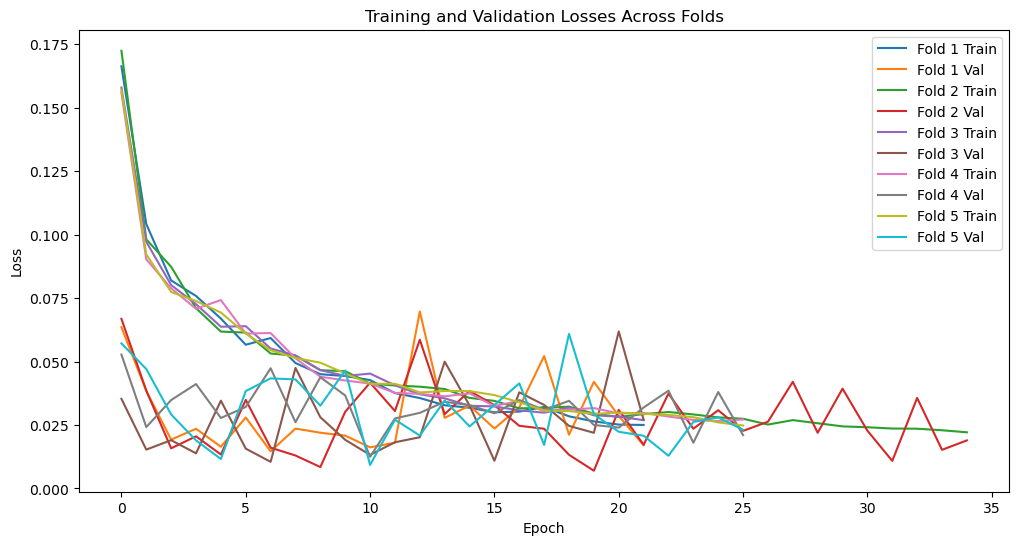

In [74]:
# Plot cross-validation results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for fold in range(len(fold_results['train_losses'])):
    plt.plot(fold_results['train_losses'][fold], label=f'Fold {fold+1} Train')
    plt.plot(fold_results['val_losses'][fold], label=f'Fold {fold+1} Val')
plt.title('Training and Validation Losses Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# PREDICTIONS

In [94]:
def extract_week_number(x):
    """
    Helper function to extract week number from either string or integer input.
    
    Args:
        x: Input week value, either string like "2024 01" or integer
    
    Returns:
        int: Week number
    """
    if isinstance(x, str):
        return int(x.split()[1])  # Extract week from "YYYY WW" format
    elif isinstance(x, (int, float)):
        return int(x)  # Already a number, just convert to int
    else:
        raise ValueError(f"Unexpected week format: {x}")

def prepare_prediction_data(input_data, n_lags=4):
    """
    Prepare input data for prediction with robust week number handling.
    
    Args:
        input_data (pd.DataFrame): New data to prepare for predictions
        n_lags (int): Number of previous weeks to use as lag features
    """
    # Ensure input_data is a DataFrame
    if not isinstance(input_data, pd.DataFrame):
        input_data = pd.DataFrame(input_data)
    
    # Create a copy to avoid modifying the original data
    processed_data = input_data.copy()
    
    # Extract week numbers robustly
    processed_data['WEEK_NUMBER'] = processed_data['ORDERWEEK'].apply(extract_week_number)
    
    # Create cyclical features
    processed_data['WEEK_SIN'] = np.sin(2 * np.pi * processed_data['WEEK_NUMBER']/53)
    processed_data['WEEK_COS'] = np.cos(2 * np.pi * processed_data['WEEK_NUMBER']/53)
    
    # Sort data by customer and week
    processed_data = processed_data.sort_values(['CUSTOMER_NAME', 'WEEK_NUMBER'])
    
    # Create lag features with forward fill for missing values
    for lag in range(1, n_lags + 1):
        processed_data[f'ORDER_LAG_{lag}'] = processed_data.groupby('CUSTOMER_NAME')['ORDERVOLUME'].shift(lag)
        # Fill missing lags with the mean of available lags or 0 if none available
        processed_data[f'ORDER_LAG_{lag}'].fillna(processed_data['ORDERVOLUME'].mean(), inplace=True)
    
    # Create rolling statistics with shorter window if needed
    processed_data['ORDER_ROLLING_MEAN'] = processed_data.groupby('CUSTOMER_NAME')['ORDERVOLUME'].transform(
        lambda x: x.rolling(window=min(4, len(x)), min_periods=1).mean()
    )
    processed_data['ORDER_ROLLING_STD'] = processed_data.groupby('CUSTOMER_NAME')['ORDERVOLUME'].transform(
        lambda x: x.rolling(window=min(4, len(x)), min_periods=1).std().fillna(0)
    )
    
    # Define feature columns
    categorical_columns = ['CUSTOMER_NAME', 'ORDERTYPE', 'WAREHOUSE', 'CITY']
    numerical_columns = [
        'WEEK_SIN', 'WEEK_COS',                          
        *[f'ORDER_LAG_{i}' for i in range(1, n_lags + 1)],
        'ORDER_ROLLING_MEAN', 'ORDER_ROLLING_STD'        
    ]
    
    return processed_data, categorical_columns, numerical_columns

def make_predictions(model, input_data, encoder, scaler_features, scaler_target):
    """
    Make predictions using the trained model with robust data handling.
    
    Args:
        model: Trained neural network model
        input_data: New data to make predictions for
        encoder: Fitted OneHotEncoder from training
        scaler_features: Fitted StandardScaler for features
        scaler_target: Fitted StandardScaler for target
    
    Returns:
        pd.DataFrame: Original data with predictions added
    """
    # Prepare the data
    processed_data, categorical_columns, numerical_columns = prepare_prediction_data(input_data)
    
    # Process categorical features
    categorical_data = processed_data[categorical_columns]
    categorical_features = encoder.transform(categorical_data)
    
    # Process numerical features
    numerical_data = processed_data[numerical_columns]
    numerical_features = scaler_features.transform(numerical_data)
    
    # Combine features
    features = np.hstack([categorical_features, numerical_features])
    features_tensor = torch.FloatTensor(features)
    
    # Generate predictions
    model.eval()
    with torch.no_grad():
        predictions = model(features_tensor)
        predictions_np = predictions.numpy()
        predictions_original = scaler_target.inverse_transform(predictions_np)
    
    # Add predictions to the processed data
    processed_data['PREDICTED_VOLUME'] = predictions_original.flatten()
    return processed_data

def predict_order_volumes(model, new_data, encoder, scaler_features, scaler_target):
    """
    Convenience function to predict order volumes and return results in a DataFrame.
    """
    results = make_predictions(model, new_data, encoder, scaler_features, scaler_target)
    return results

In [87]:
# Save the trained model and preprocessing objects
torch.save({
    'model_state_dict': model.state_dict(),
    'encoder': encoder,
    'scaler_features': scaler_features,
    'scaler_target': scaler_target
}, 'order_volume_model.pth')

In [88]:
# Create test data entries
test_data = [
    # Historical data for HOME DEPOT (weeks 51-52 of 2023 and week 1 of 2024)
    {'ORDERVOLUME': 1, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2023 51'},
    {'ORDERVOLUME': 2, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2023 52'},
    {'ORDERVOLUME': 1, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2024 01'},
    
    # Historical data for MARSHALLS
    {'ORDERVOLUME': 15, 'CUSTOMER_NAME': 'MARSHALLS', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'DECATUR', 'ORDERWEEK': '2023 51'},
    {'ORDERVOLUME': 18, 'CUSTOMER_NAME': 'MARSHALLS', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'DECATUR', 'ORDERWEEK': '2023 52'},
    {'ORDERVOLUME': 19, 'CUSTOMER_NAME': 'MARSHALLS', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'DECATUR', 'ORDERWEEK': '2024 01'},
    
    # Historical data for MEIJER, INC.
    {'ORDERVOLUME': 2, 'CUSTOMER_NAME': 'MEIJER, INC.', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'LANSING', 'ORDERWEEK': '2023 51'},
    {'ORDERVOLUME': 1, 'CUSTOMER_NAME': 'MEIJER, INC.', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'LANSING', 'ORDERWEEK': '2023 52'},
    {'ORDERVOLUME': 3, 'CUSTOMER_NAME': 'MEIJER, INC.', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'ELW BHI ELWOOD IO', 'CITY': 'LANSING', 'ORDERWEEK': '2024 01'}
]

# Create DataFrame
test_df = pd.DataFrame(test_data)

# Sort the data as we did in training
test_df = test_df.sort_values(['CUSTOMER_NAME', 'ORDERWEEK'])

print("\nSample Test Data:")
print(test_df)


Sample Test Data:
   ORDERVOLUME CUSTOMER_NAME     ORDERTYPE          WAREHOUSE     CITY  \
0            1    HOME DEPOT  CollectOrder  DAL BHI DALLAS IO   DALLAS   
1            2    HOME DEPOT  CollectOrder  DAL BHI DALLAS IO   DALLAS   
2            1    HOME DEPOT  CollectOrder  DAL BHI DALLAS IO   DALLAS   
3           15     MARSHALLS  CollectOrder  ELW BHI ELWOOD IO  DECATUR   
4           18     MARSHALLS  CollectOrder  ELW BHI ELWOOD IO  DECATUR   
5           19     MARSHALLS  CollectOrder  ELW BHI ELWOOD IO  DECATUR   
6            2  MEIJER, INC.  CollectOrder  ELW BHI ELWOOD IO  LANSING   
7            1  MEIJER, INC.  CollectOrder  ELW BHI ELWOOD IO  LANSING   
8            3  MEIJER, INC.  CollectOrder  ELW BHI ELWOOD IO  LANSING   

  ORDERWEEK  
0   2023 51  
1   2023 52  
2   2024 01  
3   2023 51  
4   2023 52  
5   2024 01  
6   2023 51  
7   2023 52  
8   2024 01  


In [95]:
# Load the saved model and preprocessing objects
checkpoint = torch.load('order_volume_model.pth')
model = OrderVolumePredictor(input_dim)  # Create model with same architecture
model.load_state_dict(checkpoint['model_state_dict'])
encoder = checkpoint['encoder']
scaler_features = checkpoint['scaler_features']
scaler_target = checkpoint['scaler_target']

# Make predictions
results = predict_order_volumes(model, test_df, encoder, scaler_features, scaler_target)

# View predictions alongside original data
print(results[['CUSTOMER_NAME', 'ORDERWEEK', 'ORDERVOLUME', 'PREDICTED_VOLUME']])

  CUSTOMER_NAME  ORDERWEEK  ORDERVOLUME  PREDICTED_VOLUME
2    HOME DEPOT          1            1          0.916905
0    HOME DEPOT         51            1          0.902027
1    HOME DEPOT         52            2          0.987473
5     MARSHALLS          1           19         39.511707
3     MARSHALLS         51           15         25.737120
4     MARSHALLS         52           18         20.733185
8  MEIJER, INC.          1            3          0.920630
6  MEIJER, INC.         51            2          0.934930
7  MEIJER, INC.         52            1          0.952669


In [96]:
# First, let's create our historical data that we'll use as context
historical_data = [
    # Historical data for HOME DEPOT (known past orders)
    {'ORDERVOLUME': 1, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2023 51'},
    {'ORDERVOLUME': 2, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2023 52'},
    {'ORDERVOLUME': 1, 'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2024 01'}
]

# Now create future prediction data (notice no ORDERVOLUME)
future_data = [
    {'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2024 02'},
    {'CUSTOMER_NAME': 'HOME DEPOT', 'ORDERTYPE': 'CollectOrder', 
     'WAREHOUSE': 'DAL BHI DALLAS IO', 'CITY': 'DALLAS', 'ORDERWEEK': '2024 03'}
]

def prepare_future_predictions(historical_data, future_data, n_lags=4):
    """
    Prepare data for future predictions by combining historical and future data.
    
    Args:
        historical_data: List or DataFrame of known past orders
        future_data: List or DataFrame of future periods to predict
        n_lags: Number of previous weeks to use for lag features
    
    Returns:
        pd.DataFrame: Combined dataset ready for prediction
    """
    # Convert both to DataFrames
    hist_df = pd.DataFrame(historical_data)
    future_df = pd.DataFrame(future_data)
    
    # Add placeholder ORDERVOLUME to future data (will be filled by predictions)
    future_df['ORDERVOLUME'] = np.nan
    
    # Combine historical and future data
    combined_df = pd.concat([hist_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values(['CUSTOMER_NAME', 'ORDERWEEK'])
    
    return combined_df

def generate_future_predictions(model, historical_data, future_data, encoder, scaler_features, scaler_target):
    """
    Generate predictions for future periods using historical context.
    
    This function implements an iterative prediction approach where each prediction
    is used as context for the next prediction.
    """
    # Prepare initial combined dataset
    combined_data = prepare_future_predictions(historical_data, future_data)
    
    # Create a copy for storing final results
    results_data = combined_data.copy()
    
    # Iterate through future dates in order
    future_dates = pd.DataFrame(future_data)['ORDERWEEK'].unique()
    
    for future_date in future_dates:
        # Prepare features for current prediction
        current_data = combined_data[combined_data['ORDERWEEK'] <= future_date]
        
        # Make prediction for current date
        prediction_results = predict_order_volumes(model, current_data, encoder, scaler_features, scaler_target)
        
        # Get the prediction for the current date
        current_pred = prediction_results[prediction_results['ORDERWEEK'] == future_date]['PREDICTED_VOLUME'].values
        
        # Update the combined dataset with the prediction
        combined_data.loc[combined_data['ORDERWEEK'] == future_date, 'ORDERVOLUME'] = current_pred
        results_data.loc[results_data['ORDERWEEK'] == future_date, 'PREDICTED_VOLUME'] = current_pred
    
    return results_data

In [97]:
# Generate predictions for future weeks
results = generate_future_predictions(
    model=model,
    historical_data=historical_data,
    future_data=future_data,
    encoder=encoder,
    scaler_features=scaler_features,
    scaler_target=scaler_target
)

# Display results in a clear format
print("\nHistorical and Predicted Orders:")
print(results[['CUSTOMER_NAME', 'ORDERWEEK', 'ORDERVOLUME', 'PREDICTED_VOLUME']].sort_values(['CUSTOMER_NAME', 'ORDERWEEK']))


Historical and Predicted Orders:
  CUSTOMER_NAME ORDERWEEK  ORDERVOLUME  PREDICTED_VOLUME
0    HOME DEPOT   2023 51          1.0               NaN
1    HOME DEPOT   2023 52          2.0               NaN
2    HOME DEPOT   2024 01          1.0               NaN
3    HOME DEPOT   2024 02          NaN          1.098232
4    HOME DEPOT   2024 03          NaN          1.091151
